           % x         y  u (m/s) @ t=0  v (m/s) @ t=0  p (Pa) @ t=0  \
0     0.000000  0.012877              0              0             0   
1     0.000000  0.005802              0              0             0   
2     0.009216  0.009849              0              0             0   
3     0.014442  0.016681              0              0             0   
4     0.000000  0.023315              0              0             0   
...        ...       ...            ...            ...           ...   
1733  0.971429  0.410000              0              0             0   
1734  0.985714  0.407345              0              0             0   
1735  0.985714  0.410000              0              0             0   
1736  1.000000  0.407345              0              0             0   
1737  1.000000  0.410000              0              0             0   

      d(p;x) (N/m^3) @ t=0  d(p;y) (N/m^3) @ t=0  d(u;x) (1/s) @ t=0  \
0                        0                     0               

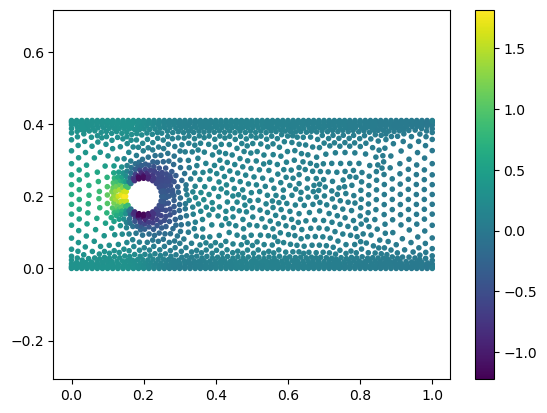

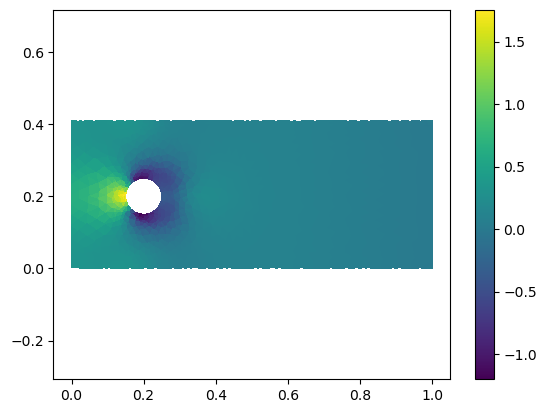

In [14]:
import re
import sys
sys.path.append('../')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

from user_fun.get_net import ForwardNetwork
from user_fun.solver.cp_solver import CloudPointSolver
from user_fun.io.read_comsol import comsol_read,process_comsol_time_table
from user_fun.pde import ico_time_pde_loss_factory
from user_fun.bc import data_loss_factory

filepath = '../dataset/comsol_cl_result.csv'

np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()


class ComsolCLDataset():
    def __init__(self,filepath):
        self.org_data = comsol_read(filepath)
        self.data = process_comsol_time_table(self.org_data)
        
    def show(self):
        # 绘制散点图
        fig, ax = plt.subplots()
        plot_x = self.org_data.iloc[:,0].values
        plot_y = self.org_data.iloc[:,1].values
        plot_c = self.org_data.iloc[:,18].values
        im = ax.scatter(plot_x, plot_y, marker= '.',c = plot_c, cmap='viridis')
        cbar = ax.figure.colorbar(im, ax=ax)
        ax.axis('equal')

        fig, ax = plt.subplots()
        triang = tri.Triangulation(plot_x, plot_y)

        # Mask off unwanted triangles.
        tri_centroid_x = plot_x[triang.triangles].mean(axis=1)
        tri_centroid_y = plot_y[triang.triangles].mean(axis=1)
        mask = np.hypot(tri_centroid_x-0.2,tri_centroid_y-0.2) < 0.05
        triang.set_mask(mask )
        cm = ax.tripcolor(triang, plot_c, cmap='viridis')

        cbar = ax.figure.colorbar(cm, ax=ax)
        ax.axis('equal')


    def patial_table(self):
        "选择部分区域"
        # 方法：通过进行筛选
        choose_time = self.data[(self.data['t']>=4.5) & (self.data['t']<=4.5)]
        cloud_points_x = np.array(choose_time[['x','y','t']].values)
        cloud_points_y = np.array(choose_time[['p (Pa)','u (m/s)','v (m/s)']].values)
        # 归一化
        # cloud_points_x = (cloud_points_x - np.mean(cloud_points_x, axis=0)) \
        #     / np.std(cloud_points_x, axis=0)
        return cloud_points_x,cloud_points_y

ds = ComsolCLDataset(filepath)
print(ds.org_data)
print(ds.data)
xdata = ds.patial_table()[0] #x,y,t
ydata = ds.patial_table()[1] #p,u,v
print('xdata is',xdata)
print('ydata is',ydata)
ds.show()

# 在解域内抽样作为数据点和残差点

resi_size = 1024
data_size = 64
resi_indices = np.random.choice(xdata.shape[0], size=resi_size, replace=False)
data_indices = np.random.choice(xdata.shape[0], size=data_size, replace=False)

resi_xdata = xdata[resi_indices]
resi_ydata = np.zeros_like(resi_xdata)
data_xdata = xdata[data_indices]
data_ydata = ydata[data_indices]

pde_loss = ico_time_pde_loss_factory(loss_fn,0.001)
data_loss = data_loss_factory(loss_fn)

solver = CloudPointSolver(
    [(data_xdata,data_ydata), (resi_xdata,resi_ydata)],
    [data_loss, pde_loss],
    model = [3, 64, 64, 64, 3],
    optimizer = "adam",
    batchsize = 'all'
)


# solver = CloudPointSolver(
#     [(data_xdata,data_ydata)],
#     [data_loss],
#     model = [3, 64, 64, 64, 3],
#     optimizer = "adam",
#     batchsize = 'all'
# )

In [15]:
perror_list,Uerror_list = [],[]
epoch_num = 20000
for i in range(epoch_num):
    solver.train_step()
    if i%10 == 0:
        print('epoch',i)
        solver.test_step(print_flag=True)

        ypred = solver.model_eval(xdata, use_best_model_flag=False)
        pdata = ydata[:,0]
        Udata = ydata[:,[1,2]]

        ppred = ypred[:,0]
        Upred = ypred[:,[1,2]]

        perror = np.abs(pdata-ppred).mean()/pdata.std()
        Uerror = np.abs(Udata-Upred).mean()/Udata.std()
        print('p:relative error',perror)
        print('U:relative error',Uerror)
        perror_list.append(perror)
        Uerror_list.append(Uerror)



epoch 0
loss is [0.25839382 0.00076109 0.25915492]
p:relative error 0.6337248364226022
U:relative error 0.7764554330975244
epoch 10
loss is [1.9013068e-01 1.0895383e-04 1.9023964e-01]
p:relative error 0.693365357717749
U:relative error 0.639436682778042
epoch 20
loss is [0.18262869 0.0001977  0.1828264 ]
p:relative error 0.6550469266652713
U:relative error 0.6216870758949276
epoch 30
loss is [1.7810738e-01 8.9520345e-06 1.7811634e-01]
p:relative error 0.6964646388021947
U:relative error 0.5607117357126484
epoch 40
loss is [1.7660367e-01 4.1895655e-05 1.7664558e-01]
p:relative error 0.6572234321661753
U:relative error 0.5663996048994046
epoch 50
loss is [1.7617951e-01 6.9983384e-06 1.7618652e-01]
p:relative error 0.6560042373703585
U:relative error 0.5677028715870207
epoch 60
loss is [1.7572431e-01 8.8243696e-06 1.7573313e-01]
p:relative error 0.6657197594773089
U:relative error 0.5644738660548823
epoch 70
loss is [1.7527017e-01 1.3032564e-05 1.7528321e-01]
p:relative error 0.6617009180

In [16]:
data_solver = CloudPointSolver(
    [(data_xdata,data_ydata)],
    [data_loss],
    model = [3, 64, 64, 64, 3],
    optimizer = "adam",
    batchsize = 'all'
)

data_perror_list,data_Uerror_list = [],[]
epoch_num = 20000
for i in range(epoch_num):
    data_solver.train_step()
    if i%10 == 0:
        print('epoch',i)
        data_solver.test_step(print_flag=True)

        data_ypred = data_solver.model_eval(xdata)
        pdata = ydata[:,0]
        Udata = ydata[:,[1,2]]

        ppred = data_ypred[:,0]
        Upred = data_ypred[:,[1,2]]

        data_perror = np.abs(pdata-ppred).mean()/pdata.std()
        data_Uerror = np.abs(Udata-Upred).mean()/Udata.std()
        print('p:relative error',data_perror)
        print('U:relative error',data_Uerror)
        data_perror_list.append(data_perror)
        data_Uerror_list.append(data_Uerror)

epoch 0
loss is [0.22310346 0.22310346]
p:relative error 0.5976684339214454
U:relative error 0.6188344891252697
epoch 10
loss is [0.1784246 0.1784246]
p:relative error 0.7114158618752756
U:relative error 0.5660264161872677
epoch 20
loss is [0.1781253 0.1781253]
p:relative error 0.6403924340084062
U:relative error 0.5655825641429789
epoch 30
loss is [0.17692465 0.17692465]
p:relative error 0.694554140680005
U:relative error 0.5657442504287662
epoch 40
loss is [0.17592543 0.17592543]
p:relative error 0.6507795483589437
U:relative error 0.565623532025472
epoch 50
loss is [0.17507565 0.17507565]
p:relative error 0.6737345242031072
U:relative error 0.5646080186548784
epoch 60
loss is [0.17450681 0.17450681]
p:relative error 0.6615339215083069
U:relative error 0.564797098440073
epoch 70
loss is [0.17417568 0.17417568]
p:relative error 0.6539353613168136
U:relative error 0.5652278734193522
epoch 80
loss is [0.1739671 0.1739671]
p:relative error 0.659659961141687
U:relative error 0.56510519146

[[0.         0.01287737 4.5       ]
 [0.         0.00580172 4.5       ]
 [0.00921584 0.00984867 4.5       ]
 ...
 [0.98571429 0.41       4.5       ]
 [1.         0.40734537 4.5       ]
 [1.         0.41       4.5       ]]


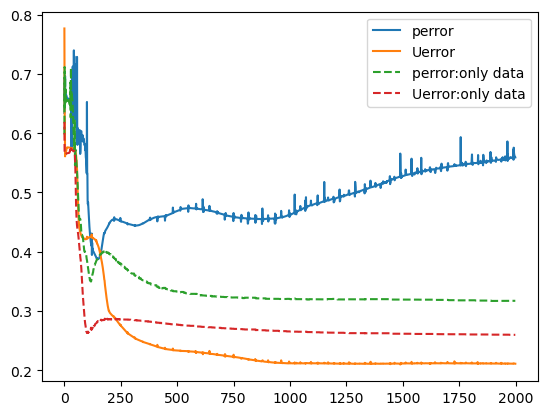

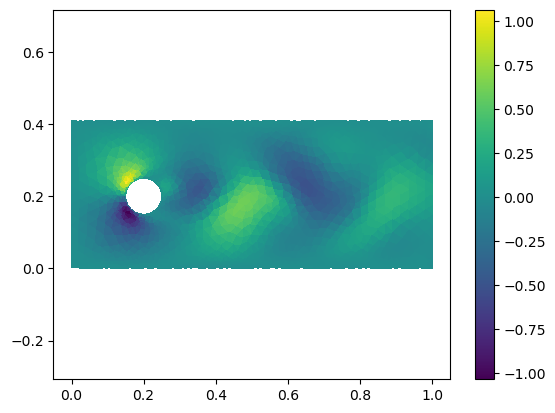

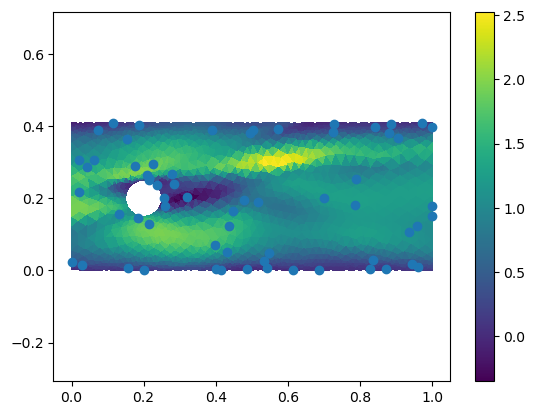

In [19]:
(fig,ax) = plt.subplots()
ax.plot(perror_list,label = 'perror')
ax.plot(Uerror_list,label = 'Uerror')
ax.plot(data_perror_list,'--',label = 'perror:only data')
ax.plot(data_Uerror_list,'--',label = 'Uerror:only data')
ax.legend()

condition = (xdata[:, 2] == 4.5)
result = xdata[condition, :]
print(result)

(fig,ax) = plt.subplots()

plot_x = result[:, 0]
plot_y = result[:, 1]
plot_c = ydata[condition, 2]
triang = tri.Triangulation(plot_x, plot_y)

# Mask off unwanted triangles.
tri_centroid_x = plot_x[triang.triangles].mean(axis=1)
tri_centroid_y = plot_y[triang.triangles].mean(axis=1)
mask = np.hypot(tri_centroid_x-0.2,tri_centroid_y-0.2) < 0.05
triang.set_mask(mask )
cm = ax.tripcolor(triang, plot_c, cmap='viridis')

cbar = ax.figure.colorbar(cm, ax=ax)
ax.axis('equal')
(fig,ax) = plt.subplots()

plot_x =  result[:, 0]
plot_y =  result[:, 1]
plot_c =  result[:, 2]

# Mask off unwanted triangles.
test_data = xdata[condition, :]
tri_centroid_x = plot_x[triang.triangles].mean(axis=1)
tri_centroid_y = plot_y[triang.triangles].mean(axis=1)
mask = np.hypot(tri_centroid_x-0.2,tri_centroid_y-0.2) < 0.05

triang.set_mask(mask )
test_pred = solver.model_eval(test_data)
cm = ax.tripcolor(triang, test_pred[:,1].ravel(), cmap='viridis')

cbar = ax.figure.colorbar(cm, ax=ax)
ax.axis('equal')

ax.scatter(data_xdata[:,0],data_xdata[:,1])